# GAP*flow* – From TFLite and ONNX to highly optimised C code running on ultra low power GAP processors

Presenter: Marco Fariselli, Embedded ML Engineer at Greenwaves-Technologies

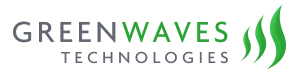

## ML Deployment Pipeline

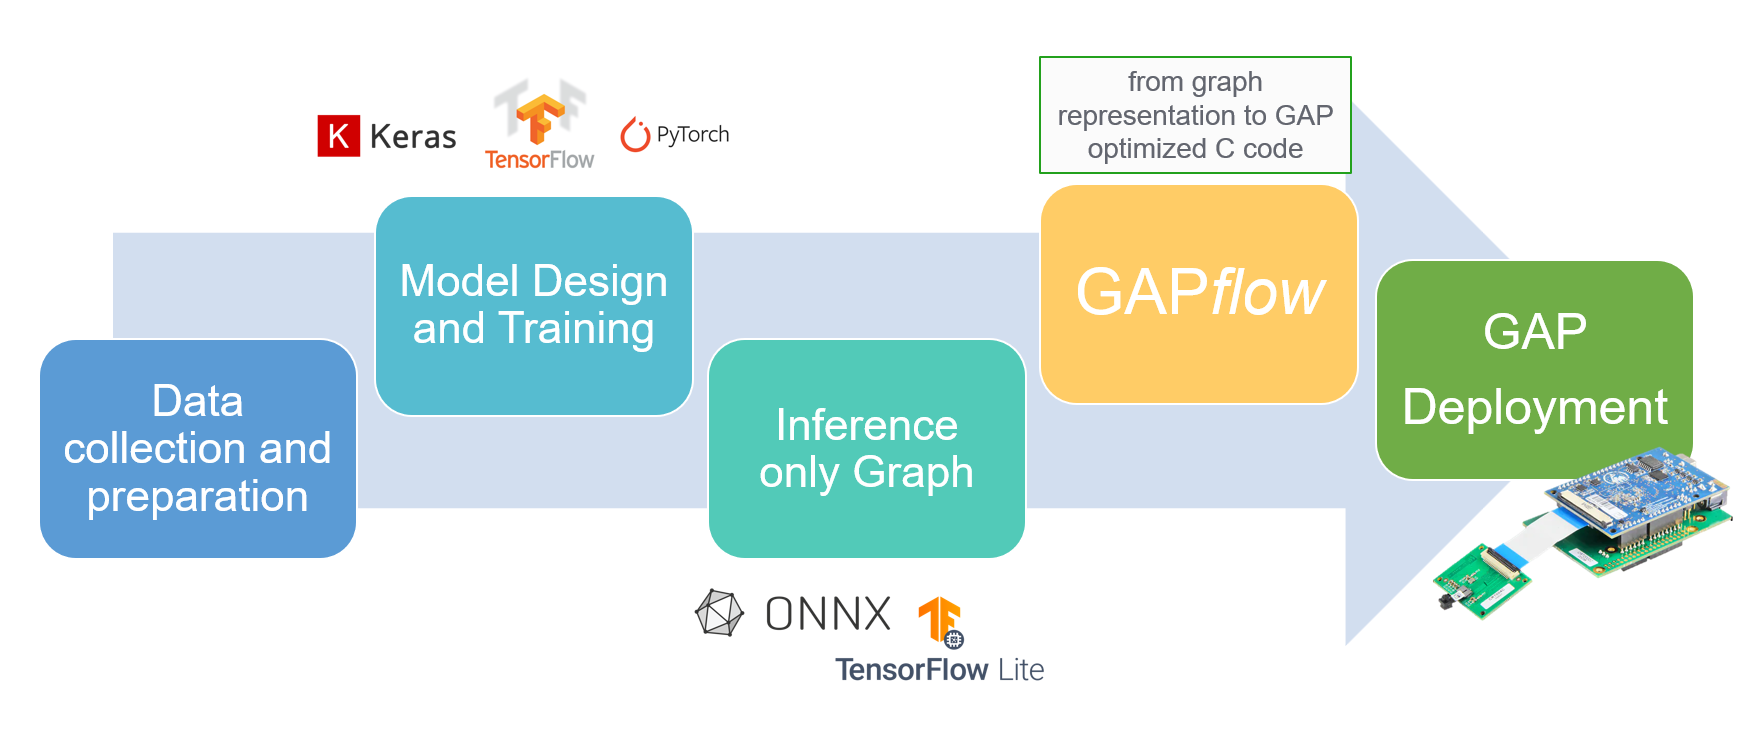

## HW Target: GAP9
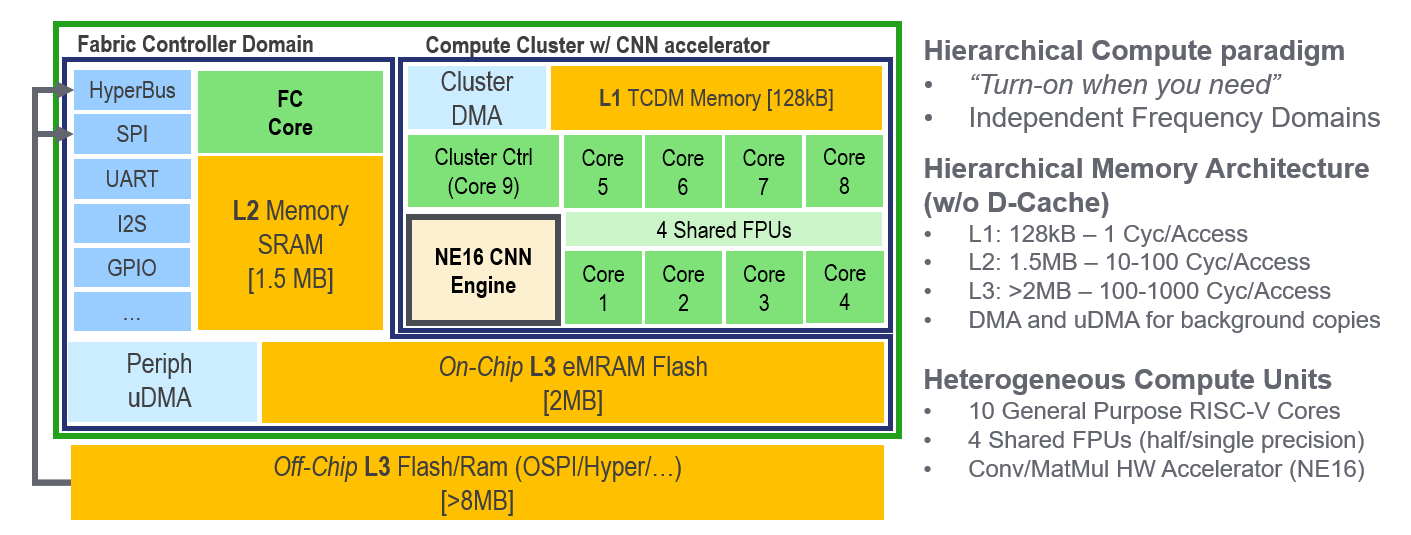

## GAP*flow* components:
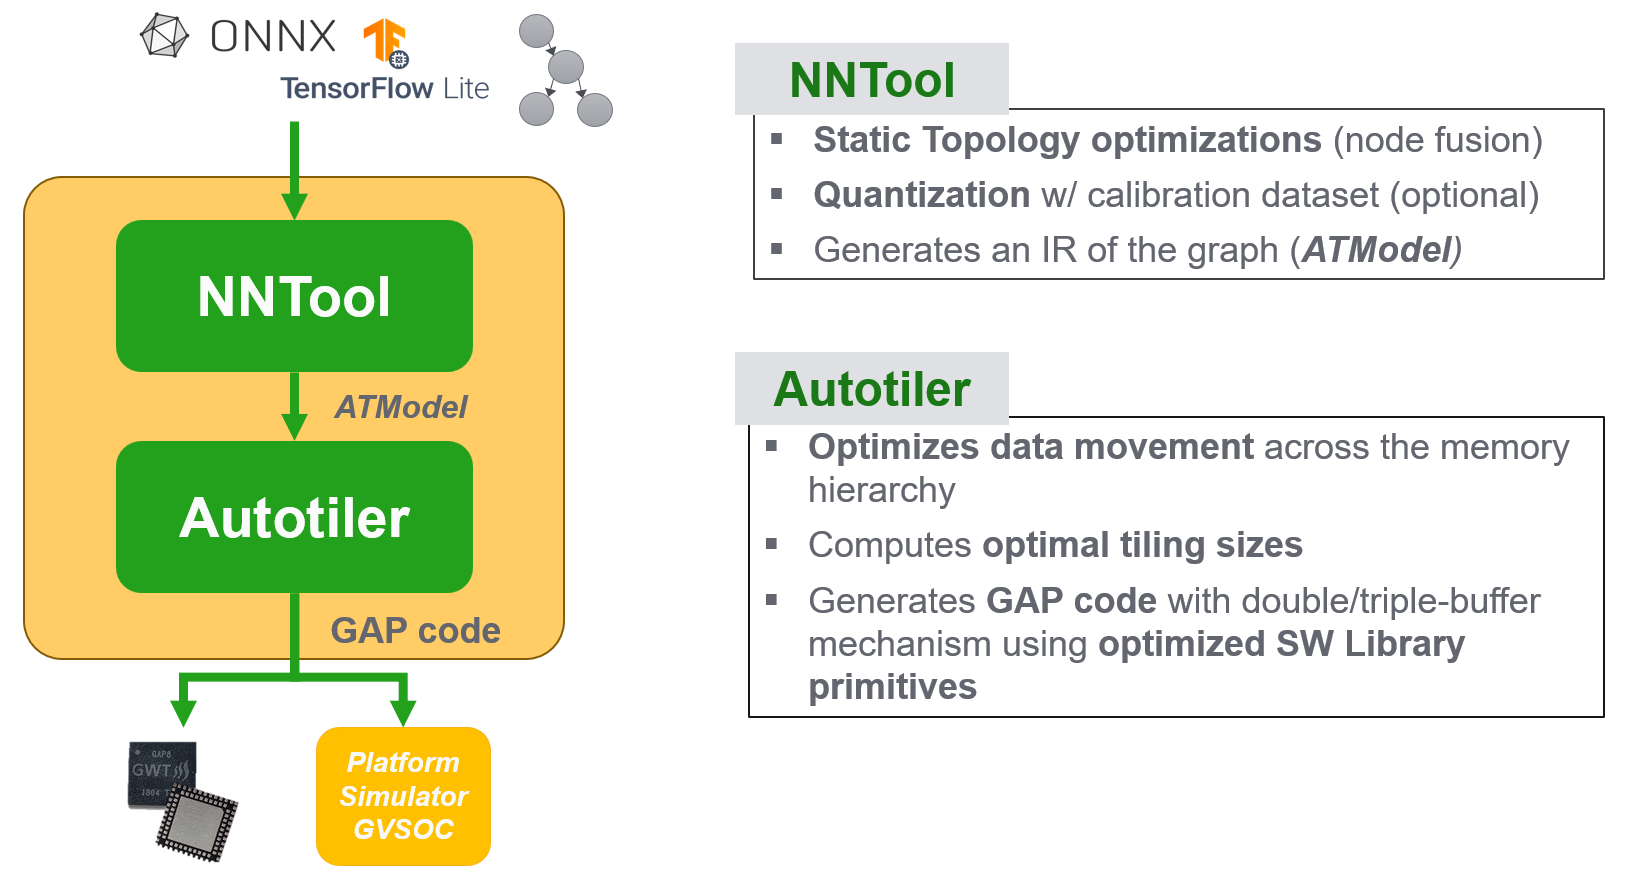

# Hands-on: COCO object detection on GAP
## Import the Model and optimize the topology
Import basic APIs from nntool module installed in the GAP SDK

In [ ]:
from nntool.api import NNGraph
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib widget
import logging
logging.basicConfig(level=logging.ERROR)

Load the TFLite graph obtained from [Tensorflow Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md) in nntool and inspect the topology

In [ ]:
G = NNGraph.load_graph("models/ssd_mobv2_quant.tflite", load_quantization=True)
max_activ_size, total_params = G.total_memory_usage
ops = G.total_ops
#G.draw(filepath="draw", view=True)

In [ ]:
print(f"{G.name}:")
print(f"\tMax Active Size:\t{max_activ_size} elements")
print(f"\tTotal # Parameters:\t{total_params} elements")
print(f"\tTotal # Operations:\t{ops / 1e6:.2f} MOps")

Convert the tensors ordering to the target SW backend library (default:CHW) and apply **Static topology optimizations**:
1. Numeric exact operator reorganization/folding (e.g. BatchNormalization folding)
2. Fuse consecutive operators together to increase computation efficiency
3. Map TFLite/ONNX operators into optimized Autotiler supported blocks

In [ ]:
G.adjust_order()
G.fusions('scaled_match_group')
G.fusions('expression_matcher')
#G.draw()
#print(G.show())

In [ ]:
G[-4].nms_score_threshold = 0.3

In [ ]:
print(G.qshow())

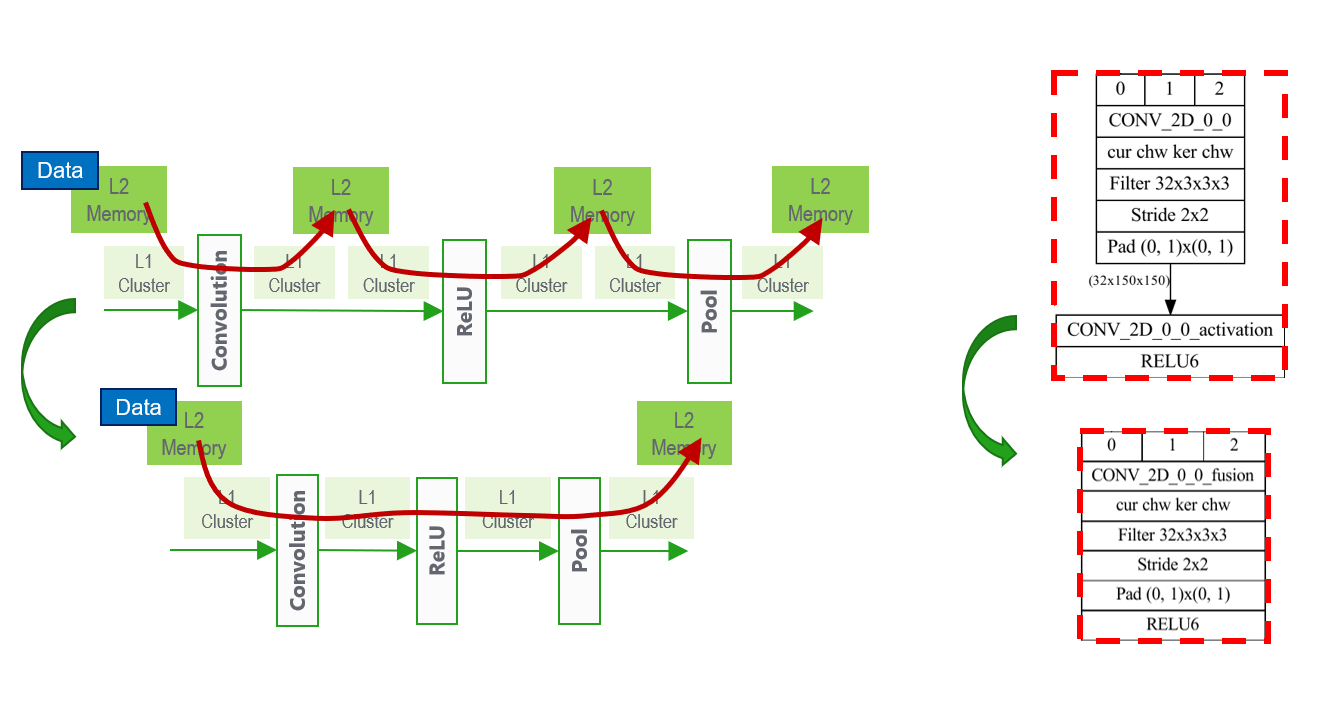

## Quantization

The most general formula to map integer values into real is the following affine transformation:

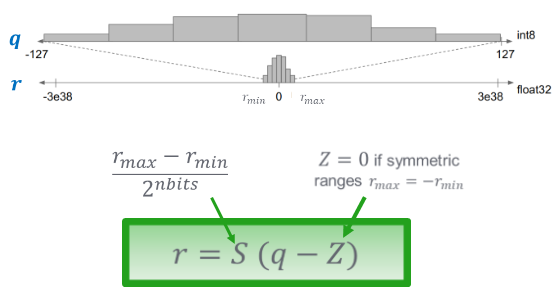

where $q$ is the quantized value (integer) representing the real value $r$. The parameters that define the quantization are:
- $ S = \frac{r_{max} - r_{min}}{2^{nbits}} $: the **Scaling Factor**. In GAP*flow* this value is always represented as exponent+mantissa (8+8bits unsigned)
- $ Z $: the **Zero Point**, i.e. the integer representation of the real value 0 (NOTE: the range is constrained to make 0 always representable). This value is always represented in the data type of $q$

The affine transformation can be applied tensor-wise ($S$ and $Z$ are scalar) or channel-wise ($S$ and $Z$ are arrays). Thanks to this representation, the operations of the graph can be moved to integer only arithmetic, leveraging HW acceleration (Conv accelerator, SIMD operations, ...). 

Accordingly to the target HW available in GAP (NE16, Cluster cores, FPUs) the supported quantization scheme might change:

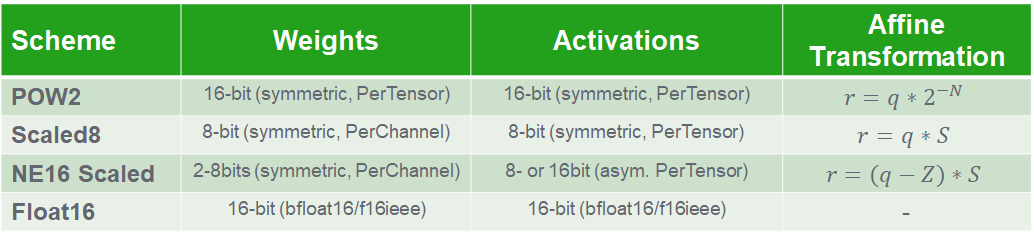

NOTE: Changing quantization type might change the target tensors ordering, for example NE16 conv accelerator works in HWC instead of default CHW. This tensor reordering is done by NNTool automatically after quantization. However the user might need to change the input order accordingly when running inference.

In order to collect $S$ and $Z$ for every tensor of the graph we need to collect statistics for intermidiate outputs.

We can use quantization statistics from tflite graph (in this case the model was quantized in tflite before export and therefore the ranges of the tensors have been loaded)

In [ ]:
G.quantize(
    statistics=None, # Already quantized in tflite --> use the statistics from the graph itself
    graph_options={
        'bits': 8,
        'use_ne16': True,
        'hwc': True
    },
)

Or we can collect again quantization statistics using NNTool numpy inference engine

In [ ]:
from tqdm import tqdm
CALIBRATION_IMGS = ["coco_test_image.ppm"]
def representative_dataset():
    for image in tqdm(CALIBRATION_IMGS):
        yield np.array(Image.open(image)) / 128 - 1

stats = G.collect_statistics(representative_dataset())
G.quantize(
    statistics=stats,
    graph_options={
        'bits': 8,
        'use_ne16': True,
        'hwc': True
    },
    # Select specific nodes and move to different quantization Scheme - TOTAL FLEXIBILITY
    #node_options={
    #    G[3].name: {
    #        "scheme": "FLOAT",
    #        "float_type": "bfloat16"
    #    },
    #    ...
    #}
)

In [ ]:
G.draw(quant_labels=True)
#print(G.qshow())

## Validate quantized model in python

Once the model is ready, we can evaluate its numerical behaviour on real samples through python APIs with bit-accurate results wrt the real HW

In [ ]:
input_image = np.array(Image.open("coco_test_image.ppm"))
# Normalize data between -1:1 as model requires
input_data = input_image / 128 - 1.0

Run inference in NNTool with full-precision and quantized backend (integer numpy: GAP9 bit-accurate). Dequantize the integer results to make the comparison with the fp32 execution (dequantize=True)

In [ ]:
float_execution = G.execute([input_data], quantize=False)
quant_execution = G.execute([input_data], quantize=True, dequantize=True)

Analize numeric differences between full precision and quantized

In [ ]:
from nntool.graph.types import ConstantInputNode
qsnrs_by_layer = G.qsnrs(float_execution, quant_execution)
print("QSNR layer by layer (skipping constant layers like weights and biases):")
print(f"{'Layer Name':>30} (  #): {'QSNR':4}")
for i, q in enumerate(qsnrs_by_layer):
    if isinstance(G[i], ConstantInputNode):
        continue
    print(f"{G[i].name:>30} ({i:3}): {q:4}")

In [ ]:
def visualize_bboxes(original_image, bboxes, classes, scores, qbboxes=None, qclasses=None, qscores=None, color="red", title=None):
    # Create figure and axes
    fig, ax = plt.subplots(1, 2 if qbboxes is not None else 1)

    h, w = input_image.shape[0], input_image.shape[1]
    for box, score, class_id in zip(bboxes, scores, classes):
        # Create a Rectangle patch
        bot, left = int(box[0] * w), int(box[1] * w)
        box_w, box_h = int((box[3]-box[1]) * w), int((box[2]-box[0]) * h)
        rect = patches.Rectangle((left, bot), box_w, box_h, linewidth=1, edgecolor=color, facecolor='none')
        ax[0].text(left, bot+box_h, int(class_id), color="g")
        ax[0].add_patch(rect)
    # Display the image
    ax[0].imshow(original_image)
    ax[0].set_title("Full-precision")

    if qbboxes is not None:
        for box, score, class_id in zip(qbboxes, qscores, qclasses):
            # Create a Rectangle patch
            bot, left = int(box[0] * w), int(box[1] * w)
            box_w, box_h = int((box[3]-box[1]) * w), int((box[2]-box[0]) * h)
            rect = patches.Rectangle((left, bot), box_w, box_h, linewidth=1, edgecolor=color, facecolor='none')
            ax[1].text(left, bot+box_h, int(class_id), color="g")
            ax[1].add_patch(rect)
        # Display the image
        ax[1].imshow(original_image)
        ax[1].set_title("Quantized")

    if title:
        fig.suptitle(title, fontsize=16)
    #fig.show()


In [ ]:
float_bboxes, float_classes, float_scores = [float_execution[out_node.step_idx][0] for out_node in G.outputs()]
quant_bboxes, quant_classes, quant_scores = [quant_execution[out_node.step_idx][0] for out_node in G.outputs()]

In [ ]:
visualize_bboxes(
    input_image, float_bboxes, float_classes, float_scores,
    quant_bboxes, quant_classes, quant_scores,
    color="red", title="Boxes predicted by NNTool model"
)

## Execute on target

Once we are fine with the numerical behaviour of the model we can run it on the HW (or gvsoc simulator) to get actual perfomance metrics

In [ ]:
# On the target only fully integer values - NO DEQUANTIZE
int_execution = G.execute([input_data], dequantize=False, quantize=True)

In [ ]:
# Autotiler options: make the autotiler allocate the input of the network and reuse that space after the first layer
# more L2 for the rest of the network
G[0].at_options.allocate = 1
G[0].at_options

In [ ]:
res = G.execute_on_target(
    pmsis_os='freertos',
    platform="gvsoc",
    directory="test_run",
    input_tensors=int_execution[0],
    output_tensors=0,
    write_out_to_file=True,
    at_log=True,
    dont_run=False,
    settings={
        'l1_size': 128000,
        'l2_size': 1300000,
        'tensor_directory': './tensors'
    },
    cmake=True,
    at_loglevel=1,
    print_output=True
)
for l in res.at_log[-29:-1]:
    print(l)

## Autotiler strategy

What's going on? A project folder is created at "directory" path (standard main function, build files, compiler flags, ...) from a standard project template. NNTool generated the *Autotiler Model* (IR) and it has been compiled and run. Extra options to the AT can be passed here like the prefered external memory or the size of the different memory levels.

![SegmentLocal](tiling.gif "segment")

The C-code generated by the Autotiler is then compiled along with the AT Library in the GAP SDK and the files generated by the project template. The application code simply takes the "input_tensors" and run inference on the target platform, then writes out the outputs to files.

In [ ]:
cyc_per_layer = np.array(res.performance)[:-1, 1].astype(np.int32)
opcyc_per_layer = np.array(res.performance)[:-1, 3].astype(np.float32)
perc_per_layer = np.array(res.performance)[:-1, -1].astype(np.float32)
names = np.array(res.performance)[:-1, 0]
def print_perf_layer(res):
    layer_idx = [n.split("_")[0][1:] for n in names]
    #print(cyc_per_layer)
    print(f"{'Layer':>40} | {'Cycles':8} | {'Op':10} | {'Op/Cyc':8} | {'%':8}\n")
    for n, cyc, op, opcyc, perc_cyc, perc_ops in res.performance:
        if n == "Total":
            print()
        print(f"{n:>40} | {cyc:8} | {op:10} | {float(opcyc):8.2f} | {float(perc_cyc):8.2f}")


In [ ]:
fig, ax = plt.subplots()
barWidth = 0.35

# Set position of bar on X axis
br1 = np.arange(len(cyc_per_layer))
br2 = [x + barWidth for x in br1]

lns = []
lns.append(
    ax.bar(br1, cyc_per_layer, width = barWidth, label="Latency")
)
ax1 = ax.twinx()
lns.append(
    ax1.bar(br2, opcyc_per_layer, width = barWidth, color="orange", label="Efficiency")
)
ax.set_xlabel('Layer Step', fontweight ='bold')#, fontsize = 15)
ax.set_ylabel('Cycles', fontweight ='bold')#, fontsize = 15)
ax1.set_ylabel('Op/Cycles', fontweight ='bold')#, fontsize = 15)
ax.set_xticks([r for r in range(len(names))], [name.split("_")[0][1:] for name in names], rotation=90)
ax.set_title("Cycles per layer")

labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper right")

plt.show()

In [ ]:
print_perf_layer(res)

In [ ]:
print("Out Name, QSNR NNTool vs Target run")
for outn in G.output_nodes():
    out_target = np.fromfile(f"test_run/{outn.name.capitalize()}.bin", G.quantization[outn.name].in_qs[0].dtype)
    out_nntool = int_execution[G[outn.name].step_idx]
    print(f"{outn.name}, {G.qsnrs([out_target], [out_nntool[0].flatten()])}")
    print(out_nntool[0].flatten())
    print(out_target)